# Определение перспективного тарифа для телеком- компании

Задание: Сделать предварительный анализ тарифов на небольшой выборке клиентов и определить, какой тариф лучше. 

Что требуется сделать:
    1. Подготовить данные: привести их к нужному типу и поработать над ошибками и аномалиями;
    2. Посчитать количество сделанных звонков и израсходованных минут разговора по месяцам, количество отправленных сообщений по месяцам, объем израсходованного интернет-трафика по месяцам и помесячную выручку для каждого пользователя;
    3. Описать поведение клиентов оператора, исходя из выборки;
    4. Проверить гипотезы. 

## Первичный анализ данных

In [1]:
#для начала импортируем библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [2]:
#теперь импортируем данные и сразу запишем их в переменные

calls_data = pd.read_csv('/datasets/calls.csv')
internet_data = pd.read_csv('/datasets/internet.csv')
messages_data = pd.read_csv('/datasets/messages.csv')
tariffs_data = pd.read_csv('/datasets/tariffs.csv')
users_data = pd.read_csv('/datasets/users.csv')

print(calls_data.info())
calls_data.head()
 
print(internet_data.info())
internet_data.head()
 
print(messages_data.info())
messages_data.head()
 
tariffs_data.head()
 
print(users_data.info())
users_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Исходя из полученных данных мы видим, что необходимо поменять формат записи дат, а также округлить время звонков и мегабайты трафика, т.е. поменять тип столбцов. 
Почти все столбцы заполнены. Только в одном столбце - churn_date в таблице users мало значений. Churn_date - дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных), соответственно данные в нем тоже корректны, скорее всего. 

## Подготовка данных

Чтобы проанализировать данные по месяцам, нам нужно добавить столбцы с месяцами в 3 таблицы: со звонками, сообщениями и интернет трафиком.
    Для этого нужно привести даты к формату Datetime. Также нужно проанализировать столбцы на предмет дубликатов.

### Работа с датами

In [3]:
#приводим в нужный формат datetime

calls_data['call_date'] = calls_data['call_date'].astype('datetime64[M]')
messages_data['message_date'] = messages_data['message_date'].astype('datetime64[M]')
internet_data['session_date'] = internet_data['session_date'].astype('datetime64[M]')
#calls_data['call_date'] = pd.to_datetime(calls_data['call_date'], format='%Y-%m-%d')
#messages_data['message_date'] = pd.to_datetime(messages_data['message_date'], format='%Y-%m-%d')
#internet_data['session_date'] = pd.to_datetime(internet_data['session_date'], format='%Y-%m-%d')


In [4]:
#добавляем столбец month в три таблицы

calls_data['month'] = pd.to_datetime(calls_data['call_date']).dt.month
messages_data['month'] = pd.to_datetime(messages_data['message_date']).dt.month
internet_data['month'] = pd.to_datetime(internet_data['session_date']).dt.month

### Работа с дубликатами

#### Датафрейм users_data
Для начала нужно проверить столбец user_id на дубликаты. 
Напишем функцию id_unique для проверки столбца с id абонента.

In [5]:
def id_unique(id_column): 
    print(id_column.value_counts())
    print()
    print(id_column.describe())
    print()
    print('Уникальных значений =',len(id_column.unique()))

In [6]:
id_unique(users_data['user_id'])

1024    1
1353    1
1366    1
1365    1
1364    1
       ..
1185    1
1184    1
1183    1
1182    1
1023    1
Name: user_id, Length: 500, dtype: int64

count     500.000000
mean     1249.500000
std       144.481833
min      1000.000000
25%      1124.750000
50%      1249.500000
75%      1374.250000
max      1499.000000
Name: user_id, dtype: float64

Уникальных значений = 500


Столбец без дубликатов, все значения идут по порядку от 1000 до 1499 - 500 уникальных значений.

Далее проверяем столбец city. В изначальном столбце 76 уникальных значений городов. Теперь приведем все названия городов к нижнему регистру и сравним их количество с количеством оригиналов.

In [7]:
#Создадим новый столбец с названиями городов. Используем метод str.lower()

users_data['city_lowercase'] = users_data['city'].str.lower()
print('Уникальных значений =',len(users_data['city_lowercase'].unique()))


Уникальных значений = 76


Количество уникальных значений в столбце совпадает, значит дубликатов нет. 

Далее проверим столбец reg_date - дата подключения тарифа (день, месяц, год).

In [8]:
display(users_data['reg_date'].sample(4))
display(users_data.head(4))
print(users_data['reg_date'].describe())

345    2018-06-01
92     2018-06-19
296    2018-06-05
189    2018-01-30
Name: reg_date, dtype: object

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,city_lowercase
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,краснодар
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,москва
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,стерлитамак
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,москва


count            500
unique           270
top       2018-05-28
freq               8
Name: reg_date, dtype: object


Данные в порядке.

Следующим на проверке столбец tariff - название тарифного плана. Здесь проверим значение. Должно быть 2 тарифа

In [9]:
users_data['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

Все правильно, идем дальше.

Проверим на всякий случай наличие дубликатов, исключая столбец user_id. 

In [10]:
print('Кол-во дубликатов =', users_data.loc[:,['age', 'churn_date', 'city', 'first_name', \
                                          'last_name', 'reg_date', 'tariff']].duplicated().sum())

Кол-во дубликатов = 0


#### Датафрейм calls_data. 
Для начала проверим столбец id -уникальный номер звонка. 

In [11]:
print(calls_data['id'])
print(calls_data['id'].value_counts())

0           1000_0
1           1000_1
2           1000_2
3           1000_3
4           1000_4
            ...   
202602    1499_215
202603    1499_216
202604    1499_217
202605    1499_218
202606    1499_219
Name: id, Length: 202607, dtype: object
1241_135    1
1352_218    1
1210_370    1
1267_11     1
1177_174    1
           ..
1208_416    1
1435_335    1
1491_282    1
1254_542    1
1460_551    1
Name: id, Length: 202607, dtype: int64


Все идентификаторы уникальны и в одном экземпляре. Следующий столбец call_date - дата звонка

In [12]:
display(calls_data)
(calls_data['call_date'].describe())

,id,call_date,duration,user_id,month
0,1000_0,2018-07-01,0.00,1000,7
1,1000_1,2018-08-01,0.00,1000,8
2,1000_2,2018-06-01,2.85,1000,6
3,1000_3,2018-09-01,13.80,1000,9
4,1000_4,2018-12-01,5.18,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-01,0.76,1499,12
202603,1499_216,2018-10-01,18.83,1499,10
202604,1499_217,2018-11-01,10.81,1499,11
202605,1499_218,2018-10-01,4.27,1499,10


/tmp/ipykernel_110/129076191.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  (calls_data['call_date'].describe())


count                  202607
unique                     12
top       2018-12-01 00:00:00
freq                    33987
first     2018-01-01 00:00:00
last      2018-12-01 00:00:00
Name: call_date, dtype: object

Тип данных изменили, остальное в порядке(365 дат = кол-ву дней в году). Столбец готов. 
Следующий столбец duration - длительность звонка в минутах. 

In [13]:
display(calls_data['duration'])
display(calls_data['duration'].describe())

0          0.00
1          0.00
2          2.85
3         13.80
4          5.18
          ...  
202602     0.76
202603    18.83
202604    10.81
202605     4.27
202606    19.62
Name: duration, Length: 202607, dtype: float64

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

Выбросов нет. Вполне правдоподобно - длительность от 0 до 38 минут (0 минут - это скорее всего те, кто звонил и не дозвонился - неотвеченный вызов).

В условии задачи сказано : «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

Поэтому округлим в большую сторону все значения столбца и поменяем тип на int.

In [14]:
# Функция округления в бОльшую сторону. Принимает число, возвращает округленное в бОльшую сторону.

def round_up(fl): 
    if int(fl)==fl:
        return fl
    else:
        return int(fl)+1

calls_data['duration'] = calls_data['duration'].apply(round_up).astype(int)
display(calls_data['duration'])

0          0
1          0
2          3
3         14
4          6
          ..
202602     1
202603    19
202604    11
202605     5
202606    20
Name: duration, Length: 202607, dtype: int64

Сравнив с первоначальными значениями видно, что все получилось. Столбец готов.
Далее берем столбец user_id - идентификатор пользователя, сделавшего звонок. В этом столбце важно проверить, чтобы не было дубликатов, так как user_id - уникальный ключ, а также посмотрим разброс значений (все ли четырехзначные - однотипные).

In [15]:
#Функция была описана выше

id_unique(calls_data['user_id'])

1377    1760
1168    1692
1375    1560
1453    1440
1196    1240
        ... 
1397      33
1442      28
1373      24
1016      20
1257      14
Name: user_id, Length: 492, dtype: int64

count    202607.000000
mean       1253.940619
std         144.722751
min        1000.000000
25%        1126.000000
50%        1260.000000
75%        1379.000000
max        1499.000000
Name: user_id, dtype: float64

Уникальных значений = 492


Похоже что 8 абонентов за год не разговаривали по телефону. Это вполне возможно. 
Возможно это GPS трекеры или 4G-модемы, где нужен только интернет. На всякий случай вычислим id этих абонентов и запишем в список not_calling_id.

In [16]:
#Напишем цикл, чтобы записать этих 8 абонентов в отдельный список

not_calling_id = []
for i in users_data['user_id']:
    if i not in calls_data['user_id'].unique(): 
        not_calling_id.append(i) 
print(not_calling_id)

[1091, 1106, 1128, 1231, 1328, 1371, 1473, 1489]


В таблице calls_data скоректированы (округлены) данные в столбце duration. 
Также замечено, что присутствуют не звонившие абоненты, - их user_id записан в список not_calling_id. 
В остальном всё в порядке. Таблица готова.

#### Датафрейм messages_data
Проверим столбец message_date - дата сообщения.  

In [17]:
display(messages_data['message_date'])

0        2018-06-01
1        2018-10-01
2        2018-08-01
3        2018-06-01
4        2018-12-01
            ...    
123031   2018-12-01
123032   2018-09-01
123033   2018-09-01
123034   2018-11-01
123035   2018-11-01
Name: message_date, Length: 123036, dtype: datetime64[ns]

In [18]:
display(messages_data['message_date'].sample(4))
print(messages_data['message_date'].describe())

34293   2018-09-01
54376   2018-09-01
42986   2018-10-01
36742   2018-11-01
Name: message_date, dtype: datetime64[ns]

count                  123036
unique                     12
top       2018-12-01 00:00:00
freq                    20555
first     2018-01-01 00:00:00
last      2018-12-01 00:00:00
Name: message_date, dtype: object


/tmp/ipykernel_110/3599906606.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(messages_data['message_date'].describe())


В данных отсутствуют данные за 1 января 2018. Возможно этот день и так следует исключить из анализа, тк 
скорее всего в нем присутствуют аномальные выбросы - в праздничные дни много звонков и сообщений с поздравлениями.
Следующим проверим столбец user_id - идентификатор пользователя, отправившего сообщение

In [19]:
id_unique(messages_data['user_id'])

1277    1463
1089    1408
1231    1384
1385    1380
1356    1224
        ... 
1111       6
1279       5
1074       3
1159       2
1141       1
Name: user_id, Length: 426, dtype: int64

count    123036.000000
mean       1256.989410
std         143.523967
min        1000.000000
25%        1134.000000
50%        1271.000000
75%        1381.000000
max        1499.000000
Name: user_id, dtype: float64

Уникальных значений = 426


Распределение вполне плавное и в рамках 1000-1499. 
Есть абоненты которые рассылают аж свыше 1000 сообщений. 
Это скорее всего какие-то сервисы, интернет магазины (зарегистрированные на ип). 
74 абонента (500-426) не отправляли сообщения: тоже вполне вероятно, 
сейчас очень многие пользуются интернет-мессенджерами.

Вычислим id этих абонентов и запишем в список not_messaging_id

In [20]:
#Напишем цикл, чтобы записать этих абонентов в отдельный список

not_messaging_id = []
for i in users_data['user_id']:
    if i not in messages_data['user_id'].unique(): 
        not_messaging_id.append(i) 
print(not_messaging_id)

[1001, 1006, 1010, 1017, 1024, 1040, 1049, 1053, 1063, 1078, 1085, 1095, 1101, 1107, 1114, 1116, 1117, 1118, 1120, 1128, 1129, 1132, 1143, 1152, 1153, 1157, 1162, 1175, 1177, 1179, 1185, 1195, 1201, 1204, 1208, 1210, 1220, 1224, 1225, 1228, 1240, 1242, 1248, 1254, 1255, 1260, 1290, 1291, 1292, 1297, 1301, 1305, 1306, 1322, 1334, 1339, 1360, 1363, 1367, 1370, 1371, 1376, 1388, 1397, 1428, 1429, 1435, 1442, 1456, 1462, 1466, 1469, 1479, 1494]


В таблице messages_data замечено, что присутствуют не писавшие СМС абоненты, - их user_id записан в список not_messaging_id. 
В остальном всё в порядке.

#### Датафрейм internet_data

In [21]:
display(internet_data.info())
display(internet_data)
print(internet_data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
 5   month         149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 6.8+ MB


None

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-01,1000,11
1,1,1000_1,1052.81,2018-09-01,1000,9
2,2,1000_2,1197.26,2018-06-01,1000,6
3,3,1000_3,550.27,2018-08-01,1000,8
4,4,1000_4,302.56,2018-09-01,1000,9
...,...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-01,1499,10
149392,149392,1499_153,490.13,2018-12-01,1499,12
149393,149393,1499_154,0.00,2018-10-01,1499,10
149394,149394,1499_155,1246.32,2018-11-01,1499,11


Index(['Unnamed: 0', 'id', 'mb_used', 'session_date', 'user_id', 'month'], dtype='object')


По условию в таблице должно быть 5 столбцов (мы еще добавили столбец month), а их 6. 
Присутствует столбец 'Unnamed: 0' данные в котором похожи на индексы. Удалим этот столбец.

In [22]:
internet_data.drop('Unnamed: 0', axis=1, inplace=True)
display(internet_data)

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-01,1000,11
1,1000_1,1052.81,2018-09-01,1000,9
2,1000_2,1197.26,2018-06-01,1000,6
3,1000_3,550.27,2018-08-01,1000,8
4,1000_4,302.56,2018-09-01,1000,9
...,...,...,...,...,...
149391,1499_152,318.90,2018-10-01,1499,10
149392,1499_153,490.13,2018-12-01,1499,12
149393,1499_154,0.00,2018-10-01,1499,10
149394,1499_155,1246.32,2018-11-01,1499,11


Ненужный столбец удален.
Далее столбец mb_used - объём потраченного за сессию интернет-трафика (в мегабайтах).

In [23]:
display(internet_data['mb_used'])
display(internet_data['mb_used'].describe())

0          112.95
1         1052.81
2         1197.26
3          550.27
4          302.56
           ...   
149391     318.90
149392     490.13
149393       0.00
149394    1246.32
149395     544.37
Name: mb_used, Length: 149396, dtype: float64

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

Выбросов нет. Использование трафика от 0 до 1725 МБ 
(0 МБ - это похоже случаи когда соединение было установлено с интернетом, а потом сразу прервано).
Поэтому округлим в большую сторону все значения столбца и поменяем тип на int.

In [24]:
# Функция была прописана выше: принимает число, возвращает округленное в бОльшую сторону.
internet_data['mb_used'] = internet_data['mb_used'].apply(round_up).astype(int)
display(internet_data['mb_used'])

0          113
1         1053
2         1198
3          551
4          303
          ... 
149391     319
149392     491
149393       0
149394    1247
149395     545
Name: mb_used, Length: 149396, dtype: int64

Сравнив с первоначальными значениями видно, что все получилось. Столбец готов. Далее столбец session_date - дата интернет-сессии. 

In [25]:
display(internet_data['session_date'].sample(4))
display(internet_data.head(4))
print(internet_data['session_date'].describe())

118460   2018-09-01
142115   2018-12-01
107413   2018-09-01
146499   2018-08-01
Name: session_date, dtype: datetime64[ns]

,id,mb_used,session_date,user_id,month
0,1000_0,113,2018-11-01,1000,11
1,1000_1,1053,2018-09-01,1000,9
2,1000_2,1198,2018-06-01,1000,6
3,1000_3,551,2018-08-01,1000,8


count                  149396
unique                     12
top       2018-12-01 00:00:00
freq                    24799
first     2018-01-01 00:00:00
last      2018-12-01 00:00:00
Name: session_date, dtype: object


/tmp/ipykernel_110/1225223701.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(internet_data['session_date'].describe())


Присутствуют данные за все 365 дней. Столбец в порядке. Следующий столбец user_id - идентификатор пользователя. 

In [26]:
id_unique(internet_data['user_id'])

1496    834
1227    812
1204    789
1240    764
1251    759
       ... 
1151     35
1467     27
1343     26
1192     22
1399      8
Name: user_id, Length: 497, dtype: int64

count    149396.000000
mean       1252.099842
std         144.050823
min        1000.000000
25%        1130.000000
50%        1251.000000
75%        1380.000000
max        1499.000000
Name: user_id, dtype: float64

Уникальных значений = 497


Из 500 абонентов всего 3 не пользовалиcь интернетом, возможно это пожилые люди.
Вычислим id этих абонентов и запишем в список not_interneting_id.

In [27]:
not_interneting_id = []
for i in users_data['user_id']:
    if i not in internet_data['user_id'].unique(): 
        not_interneting_id.append(i) 
print(not_interneting_id)

[1128, 1273, 1371]


В таблице internet_data кол-во использованных абонентом МБ mb_used округлено до целого вверх. Также замечено, что присутствуют 3 абонента не пользовавшихся интернетом, - их user_id записан в список not_interneting_id. В остальном всё в порядке. Датафрейм готов. 

#### Датафрейм tariffs_data

In [28]:
display(tariffs_data.info())
display(tariffs_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В датафрейме всего две строки - два разных тарифа, данные в порядке.

Вывод: По большей части данные изначально в хорошем состоянии. Изменены типы в столбцах с датами на datetime64, и проверена корректность данных, в 3 датафрейма добавлен столбец month для дальнейшего анализа. Дубликатов не было выявлено. 

## Расчет показателей для каждого абонента

 По условиям задачи требуется посчитать количество сделанных звонков и израсходованных минут 
разговора по месяцам, количество отправленных сообщений по месяцам, 
объем израсходованного интернет-трафика по месяцам и помесячную выручку для каждого пользователя.
Но предварительно создадим 3 таблицы ab_calls, ab_messages, ab_internet сгруппированные по user_id и month, 
в которых будет записан результат выполнения первых трех заданий для слияния в общую таблицу abonents.

In [29]:
abonent = pd.DataFrame()

ab_calls = calls_data.groupby(['user_id', 'month'])['duration'].agg(['count','sum']).reset_index()
ab_calls.columns = ['user_id', 'month', 'calls', 'min']

ab_messages = messages_data.groupby(['user_id', 'month'])['id'].count().reset_index()
ab_messages.columns = ['user_id', 'month', 'mes']

ab_internet = internet_data.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
ab_internet.columns = ['user_id', 'month', 'mb']

display(ab_calls.head(10))
display(ab_messages.head(10))
display(ab_internet.head(10))

,user_id,month,calls,min
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466
5,1000,10,57,350
6,1000,11,43,338
7,1000,12,46,333
8,1001,11,59,430
9,1001,12,63,414


,user_id,month,mes
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


,user_id,month,mb
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581
5,1000,10,14717
6,1000,11,14768
7,1000,12,9827
8,1001,11,18452
9,1001,12,14053


Теперь создадим из 3 таблиц ab_calls, ab_messages, ab_internet главную таблицу abonents.

In [30]:
all_abonents = users_data.loc[:,['user_id', 'city', 'tariff']]

# Таблицу abonents получаем путем слияния, используя метод merge

abonents = pd.merge(ab_calls, ab_messages, how='outer', on=['user_id', 'month']) 
abonents = pd.merge(abonents, ab_internet, how='outer', on=['user_id', 'month']) 
abonents = pd.merge(abonents, all_abonents, how='outer', on=['user_id'])
abonents

,user_id,month,calls,min,mes,mb,city,tariff
0,1000,5.0,22.0,159.0,22.0,2256.0,Краснодар,ultra
1,1000,6.0,43.0,172.0,60.0,23257.0,Краснодар,ultra
2,1000,7.0,47.0,340.0,75.0,14016.0,Краснодар,ultra
3,1000,8.0,52.0,408.0,81.0,14070.0,Краснодар,ultra
4,1000,9.0,58.0,466.0,57.0,14581.0,Краснодар,ultra
...,...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,NaN,21.0,19588.0,Санкт-Петербург,smart
3212,1489,11.0,NaN,NaN,20.0,17516.0,Санкт-Петербург,smart
3213,1489,12.0,NaN,NaN,35.0,17341.0,Санкт-Петербург,smart
3214,1128,NaN,NaN,NaN,NaN,NaN,Волжский,ultra


В предобработке было выявлены абоненты которые не звонили, не писали СМС, не пользовались интернетом.

In [31]:
print(not_calling_id) # не звонили
print(not_interneting_id) # не писали СМС
print(not_messaging_id) # не пользовались интернетом

[1091, 1106, 1128, 1231, 1328, 1371, 1473, 1489]
[1128, 1273, 1371]
[1001, 1006, 1010, 1017, 1024, 1040, 1049, 1053, 1063, 1078, 1085, 1095, 1101, 1107, 1114, 1116, 1117, 1118, 1120, 1128, 1129, 1132, 1143, 1152, 1153, 1157, 1162, 1175, 1177, 1179, 1185, 1195, 1201, 1204, 1208, 1210, 1220, 1224, 1225, 1228, 1240, 1242, 1248, 1254, 1255, 1260, 1290, 1291, 1292, 1297, 1301, 1305, 1306, 1322, 1334, 1339, 1360, 1363, 1367, 1370, 1371, 1376, 1388, 1397, 1428, 1429, 1435, 1442, 1456, 1462, 1466, 1469, 1479, 1494]


Есть 2 абонента, которые одновременно не звонили, не писали СМС, не пользовались интернетом:
их user_id 1128 и 1371

In [32]:
display(users_data.loc[users_data['user_id']==1128])
display(users_data.loc[users_data['user_id']==1371])

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,city_lowercase
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,волжский


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,city_lowercase
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,омск


Видно что эти абоненты подключились в конце года, и видимо не успели воспользоваться телефоном

Чтобы посчитать выручку (income) за месяц надо избавиться от пропусков NaN. 
Логично заполнить их нулями. 
Посмотрим сколько у нас пропусков в таблице abonents

In [33]:
abonents.isna().sum()

user_id      0
month        2
calls       42
min         42
mes        499
mb          13
city         0
tariff       0
dtype: int64

In [34]:
display(abonents[abonents['month'].isna()])

,user_id,month,calls,min,mes,mb,city,tariff
3214,1128,NaN,NaN,NaN,NaN,NaN,Волжский,ultra
3215,1371,NaN,NaN,NaN,NaN,NaN,Омск,smart


Оказывается есть пропуски в столбце month. Это как раз те 2 абонента подключенных в конце года, поэтому 
ставим в столбце с месяцем 12 (декабрь) и будем считать, что выручка в декабре будет равна абонентской 
плате.

In [35]:
abonents.loc[:,['calls', 'min', 'mes', 'mb']] = abonents.loc[:,['calls', 'min', 'mes', 'mb']].fillna(0)
abonents.loc[:,['month']] = abonents.loc[:,['month']].fillna(12)
abonents.isna().sum()

user_id    0
month      0
calls      0
min        0
mes        0
mb         0
city       0
tariff     0
dtype: int64

### Cтолбец income 
Добавим новый столбец в таблицу abonents. Напишем функцию income_month, которая принимает строку, и возвращает значение выручки. Вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану.

In [36]:
def income_month(ab_month):
        
    if ab_month['tariff'] == 'smart':
        
        inc_calls = (ab_month['min'] - tariffs_data.loc[0,'minutes_included']) * tariffs_data.loc[0,'rub_per_minute']
        if inc_calls < 0 :
            inc_calls = 0
        
        inc_mess = (ab_month['mes'] - tariffs_data.loc[0,'messages_included']) * tariffs_data.loc[0,'rub_per_message']
        if inc_mess < 0 :
            inc_mess = 0
        
        # round_up(fl) - Функция округления в бОльшую сторону. Описывалась выше
        inc_mb  = round_up((ab_month['mb'] - tariffs_data.loc[0,'mb_per_month_included'])/1024) * tariffs_data.loc[0,'rub_per_gb'] 
        if inc_mb < 0 :
            inc_mb = 0
             
        inc = inc_calls + inc_mess + inc_mb + tariffs_data.loc[0,'rub_monthly_fee']
        
    elif ab_month['tariff'] == 'ultra':
        
        inc_calls = (ab_month['min'] - tariffs_data.loc[1,'minutes_included']) * tariffs_data.loc[1,'rub_per_minute']
        if inc_calls < 0 :
            inc_calls = 0
        
        inc_mess = (ab_month['mes'] - tariffs_data.loc[1,'messages_included']) * tariffs_data.loc[1,'rub_per_message']
        if inc_mess < 0 :
            inc_mess = 0
        
        inc_mb  = round_up((ab_month['mb'] - tariffs_data.loc[1,'mb_per_month_included'])/1024) * tariffs_data.loc[1,'rub_per_gb'] 
        if inc_mb < 0 :
            inc_mb = 0
             
        inc = inc_calls + inc_mess + inc_mb + tariffs_data.loc[1,'rub_monthly_fee']
        
    else:
        print('Неизвестный тариф :)) ')
        

    return inc

abonents['income'] = abonents.apply(income_month, axis=1)

display(abonents)

,user_id,month,calls,min,mes,mb,city,tariff,income
0,1000,5.0,22.0,159.0,22.0,2256.0,Краснодар,ultra,1950.0
1,1000,6.0,43.0,172.0,60.0,23257.0,Краснодар,ultra,1950.0
2,1000,7.0,47.0,340.0,75.0,14016.0,Краснодар,ultra,1950.0
3,1000,8.0,52.0,408.0,81.0,14070.0,Краснодар,ultra,1950.0
4,1000,9.0,58.0,466.0,57.0,14581.0,Краснодар,ultra,1950.0
...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,0.0,0.0,21.0,19588.0,Санкт-Петербург,smart,1550.0
3212,1489,11.0,0.0,0.0,20.0,17516.0,Санкт-Петербург,smart,1150.0
3213,1489,12.0,0.0,0.0,35.0,17341.0,Санкт-Петербург,smart,950.0
3214,1128,12.0,0.0,0.0,0.0,0.0,Волжский,ultra,1950.0


В итоге был создан новый датафрейм abonents,
в которую сгруппировали данные по каждому абоненту за каждый месяц пользования 
(попутно были созданы еще 3 вспомогательные таблицы). Заполнены образовавшиеся пропуски.
Рассчитаны для анализа 4 столбца: min - минут/мес, mes - СМС/мес, mb - МБ/мес и income - выручка за месяц.
Датафрейм готов для анализа.

## Анализ данных 

Требуется описать поведение клиентов оператора, исходя из выборки. 
Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого
тарифа в месяц? 
Нужно посчитать среднее количество, дисперсию и стандартное отклонение. 
Построить гистограммы и описать распределения.

### Расчет помесячного расхода минут разговора, сообщений и объёма интернет-трафика для каждого тарифа.


#### Расчет общих показателей всех клиентов по месяцам по обоим тарифам.

In [37]:
all_clients_month = abonents.groupby(['tariff', 'month'])['min', 'mes', 'mb', 'income'].sum().reset_index()
all_clients_month

/tmp/ipykernel_110/2615790949.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  all_clients_month = abonents.groupby(['tariff', 'month'])['min', 'mes', 'mb', 'income'].sum().reset_index()


,tariff,month,min,mes,mb,income
0,smart,1.0,6931.0,620.0,289831.0,24525.0
1,smart,2.0,17324.0,1397.0,673461.0,49001.0
2,smart,3.0,30034.0,2453.0,1164537.0,90476.0
3,smart,4.0,41119.0,3443.0,1509702.0,109866.0
4,smart,5.0,54618.0,4762.0,2231353.0,172049.0
5,smart,6.0,64885.0,5478.0,2593622.0,200259.0
6,smart,7.0,82079.0,6784.0,3168466.0,249614.0
7,smart,8.0,99045.0,7905.0,3908561.0,314940.0
8,smart,9.0,111439.0,8746.0,4244377.0,330386.0
9,smart,10.0,125284.0,9927.0,4932898.0,406067.0


In [38]:
# для наглядности разобьем all_clients_month на 2 датафрейма по тарифу

smart_all_clients_month = all_clients_month.query(' tariff=="smart" ')
ultra_all_clients_month = all_clients_month.query(' tariff=="ultra" ').reset_index(drop=True)

In [39]:
display(smart_all_clients_month)

,tariff,month,min,mes,mb,income
0,smart,1.0,6931.0,620.0,289831.0,24525.0
1,smart,2.0,17324.0,1397.0,673461.0,49001.0
2,smart,3.0,30034.0,2453.0,1164537.0,90476.0
3,smart,4.0,41119.0,3443.0,1509702.0,109866.0
4,smart,5.0,54618.0,4762.0,2231353.0,172049.0
5,smart,6.0,64885.0,5478.0,2593622.0,200259.0
6,smart,7.0,82079.0,6784.0,3168466.0,249614.0
7,smart,8.0,99045.0,7905.0,3908561.0,314940.0
8,smart,9.0,111439.0,8746.0,4244377.0,330386.0
9,smart,10.0,125284.0,9927.0,4932898.0,406067.0


In [40]:
display(ultra_all_clients_month)

,tariff,month,min,mes,mb,income
0,ultra,1.0,3853.0,304.0,118382.0,17550.0
1,ultra,2.0,7131.0,527.0,282887.0,47400.0
2,ultra,3.0,18117.0,1195.0,649423.0,74550.0
3,ultra,4.0,25191.0,1736.0,926409.0,110400.0
4,ultra,5.0,34192.0,2536.0,1298540.0,138600.0
5,ultra,6.0,40295.0,3505.0,1591148.0,171450.0
6,ultra,7.0,49667.0,4536.0,1866833.0,193350.0
7,ultra,8.0,54653.0,5183.0,2096565.0,223350.0
8,ultra,9.0,62036.0,6013.0,2210554.0,232950.0
9,ultra,10.0,68644.0,7187.0,2467856.0,254700.0


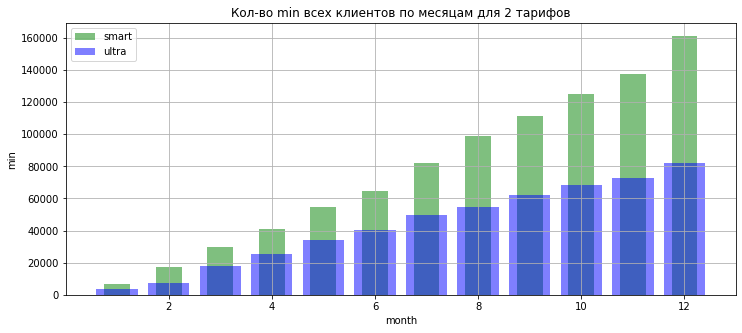

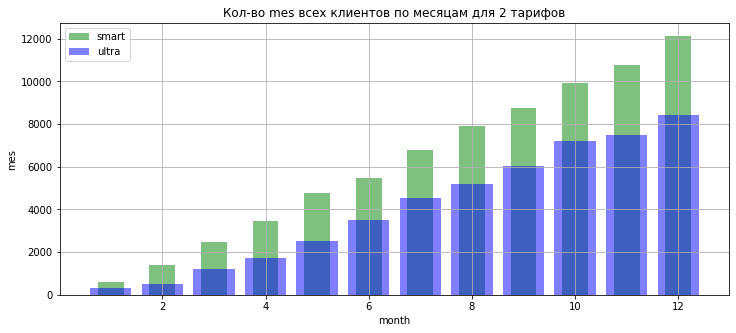

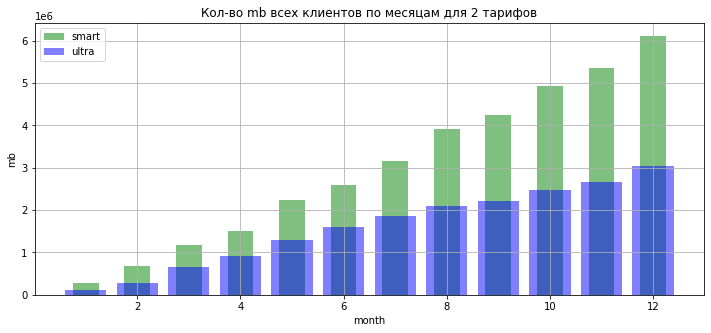

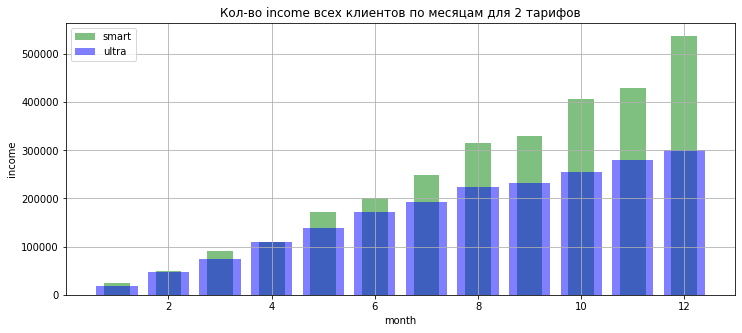

In [41]:
for param in ['min', 'mes', 'mb','income']:
    plt.figure(figsize=(12, 5))
    plt.bar(smart_all_clients_month['month'], smart_all_clients_month[param], label='smart', color='g', alpha=0.5, width=0.5)
    plt.bar(ultra_all_clients_month['month'], ultra_all_clients_month[param], label='ultra', color='b', alpha=0.5)

    plt.xlabel('month')
    plt.ylabel(param)
    plt.grid()
    plt.title(f'Кол-во {param} всех клиентов по месяцам для 2 тарифов')
    plt.legend()
    plt.show();

Дополнительно посмотрим сколько абонентов у каждого тарифа

In [42]:
users_data.tariff.value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

Из графиков очевидно, что общий расход минут, сообщений, интернет траффика всех абонентов 
тарифа 'smart' стабильно больше чем 'ultra' на 40-90%, но и абонентов у 'smart' в 2 с лишним раза больше,
чем у 'ultra'. По выручке income надо отметить что : в первой половине года абоненты обоих тарифов 
приносят почти одинаковые суммы, а во второй - абоненты smart с каждым месяцем приносят выручки 
все больше и больше вплоть до декабря, где выручка уже почти в 2 раза больше, чем от тарифа ultra. 
По всем графикам видно, что гистограммы постоянно возрастают от меcяца к месяцу - это показывает 
новый приток абонентов каждый месяц. Поэтому логично будет посчитать усредненные показатели расхода 
на одного абонента за каждый месяц и уже тогда сравнить тарифы.

#### Расчет медианных показателей клиента по месяцам по обоим тарифам.

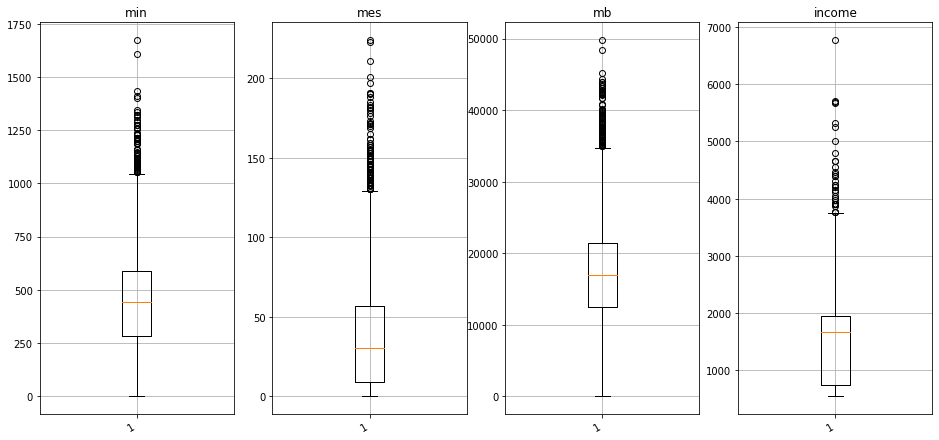

In [43]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(16, 8))

p = {ax1:'min', ax2:'mes', ax3:'mb', ax4:'income'}
for ax in [ax1, ax2, ax3, ax4]:
    ax.boxplot(abonents[p[ax]])
    ax.grid()
    ax.set_title(p[ax])

fig.autofmt_xdate()

Сильных выбросов нет, вполне адекватные числа, поэтому для вычисления усредненных значений можно использовать и среднее и медиану. Выберем медиану.

Сгруппируем и создадим новую таблицу tar - с общими данными по тарифам

In [44]:
tar = abonents.groupby(['tariff', 'month'])['min', 'mes', 'mb','income'].mean().reset_index()
display(tar)

/tmp/ipykernel_110/1079697929.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tar = abonents.groupby(['tariff', 'month'])['min', 'mes', 'mb','income'].mean().reset_index()


,tariff,month,min,mes,mb,income
0,smart,1.0,203.852941,18.235294,8524.441176,721.323529
1,smart,2.0,298.689655,24.086207,11611.396552,844.844828
2,smart,3.0,390.051948,31.857143,15123.857143,1175.012987
3,smart,4.0,367.133929,30.741071,13479.482143,980.946429
4,smart,5.0,387.361702,33.773050,15825.198582,1220.205674
5,smart,6.0,395.640244,33.402439,15814.768293,1221.091463
6,smart,7.0,408.353234,33.751244,15763.512438,1241.860697
7,smart,8.0,421.468085,33.638298,16632.174468,1340.170213
8,smart,9.0,428.611538,33.638462,16324.526923,1270.715385
9,smart,10.0,426.136054,33.765306,16778.564626,1381.180272


Теперь разделим новую таблицу на две smart и ultra - по каждому тарифу

In [45]:
smart = tar.query(' tariff=="smart" ')
ultra = tar.query(' tariff=="ultra" ')

display(smart)
display(ultra)

,tariff,month,min,mes,mb,income
0,smart,1.0,203.852941,18.235294,8524.441176,721.323529
1,smart,2.0,298.689655,24.086207,11611.396552,844.844828
2,smart,3.0,390.051948,31.857143,15123.857143,1175.012987
3,smart,4.0,367.133929,30.741071,13479.482143,980.946429
4,smart,5.0,387.361702,33.773050,15825.198582,1220.205674
5,smart,6.0,395.640244,33.402439,15814.768293,1221.091463
6,smart,7.0,408.353234,33.751244,15763.512438,1241.860697
7,smart,8.0,421.468085,33.638298,16632.174468,1340.170213
8,smart,9.0,428.611538,33.638462,16324.526923,1270.715385
9,smart,10.0,426.136054,33.765306,16778.564626,1381.180272


,tariff,month,min,mes,mb,income
12,ultra,1.0,428.111111,33.777778,13153.555556,1950.000000
13,ultra,2.0,297.125000,21.958333,11786.958333,1975.000000
14,ultra,3.0,489.648649,32.297297,17551.972973,2014.864865
15,ultra,4.0,458.018182,31.563636,16843.800000,2007.272727
16,ultra,5.0,510.328358,37.850746,19381.194030,2068.656716
17,ultra,6.0,479.702381,41.726190,18942.238095,2041.071429
18,ultra,7.0,545.791209,49.846154,20514.648352,2124.725275
19,ultra,8.0,510.775701,48.439252,19594.065421,2087.383178
20,ultra,9.0,539.443478,52.286957,19222.208696,2025.652174
21,ultra,10.0,558.081301,58.430894,20063.869919,2070.731707


Теперь нужно вычислить усредненные расходы по месяцам для одного абонента для обоих тарифов.

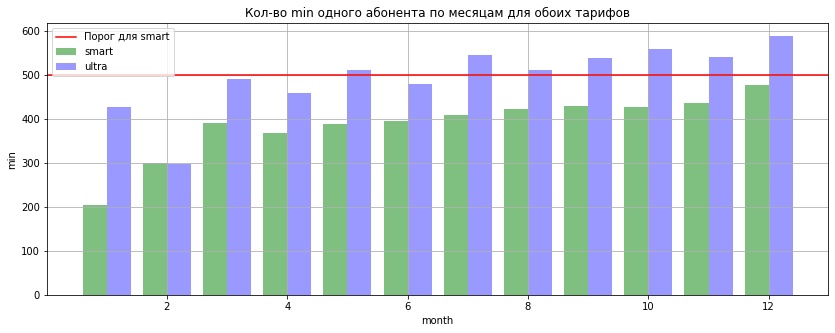

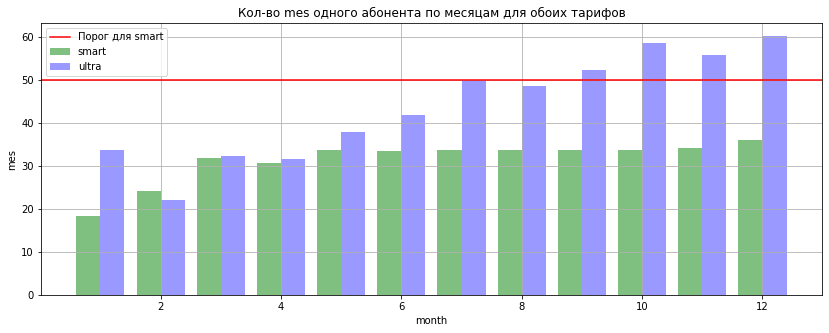

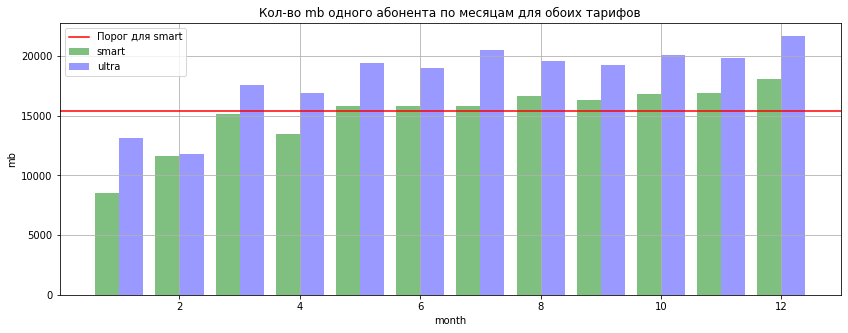

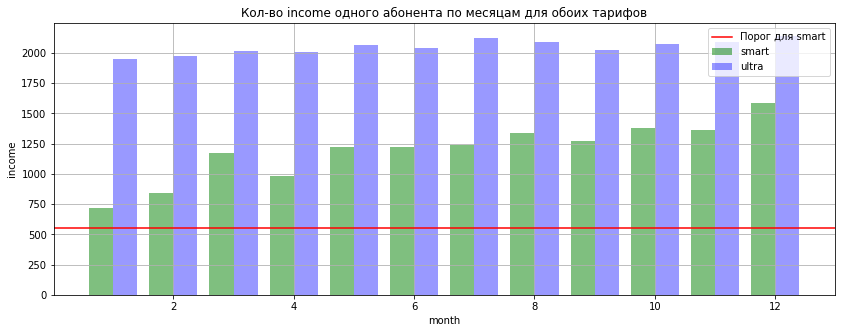

In [46]:
for param in ['min', 'mes', 'mb','income']:
    w = 0.4
    plt.figure(figsize=(14, 5))
    plt.bar(smart['month']-w/2, smart[param], label='smart', color='g', alpha=0.5, width=w)
    plt.bar(ultra['month']+w/2, ultra[param], label='ultra', color='b', alpha=0.4, width=w)

# porog- пороговое значение в smart, после которого идёт оплата сверх абонентской
    if param == 'min':
        porog=500
    elif param == 'mes':
        porog=50
    elif param == 'mb':
        porog=15360
    else:
        porog=550
        
    plt.axhline(y=porog, label='Порог для smart', color='red')  
    plt.xlabel('month')
    plt.ylabel(param)
    plt.grid()
    plt.title(f'Кол-во {param} одного абонента по месяцам для обоих тарифов')
    plt.legend()
    plt.show();

Рассчитаем усредненные значения за месяц, которые требуются абонентам в обоих тарифах.

In [47]:
print('Медианные значения абонента помесячно за 2018 год')
for parametr in ['min', 'mes', 'mb', 'income']:
    print(f'Кол-во {parametr}: smart = {round(smart[parametr].median())} / ultra = {round(ultra[parametr].median())}')

Медианные значения абонента помесячно за 2018 год
Кол-во min: smart = 402 / ultra = 511
Кол-во mes: smart = 34 / ultra = 45
Кол-во mb: smart = 15820 / ultra = 19302
Кол-во income: smart = 1231 / ultra = 2055


### Распределение абонентов по количеству использованых услуг, гистограммы

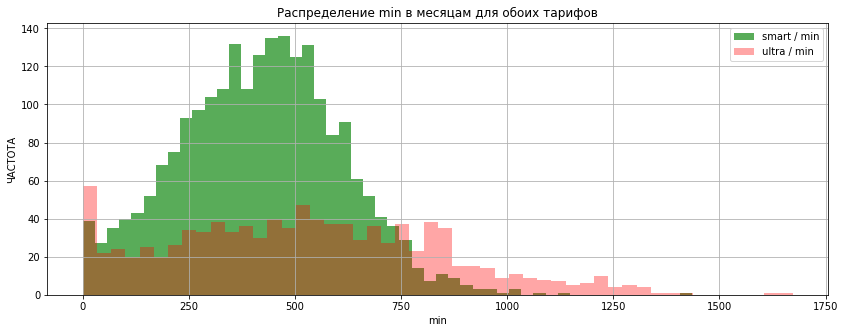

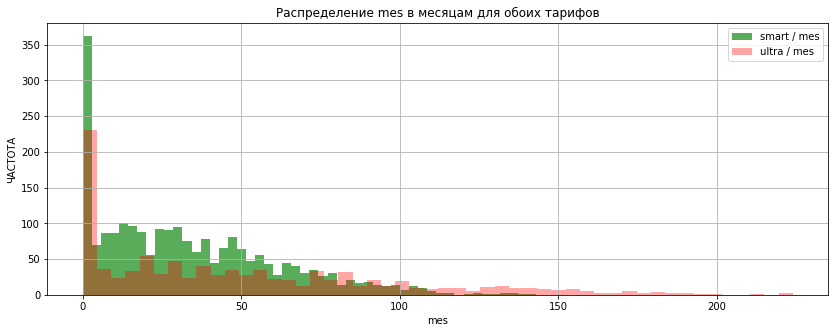

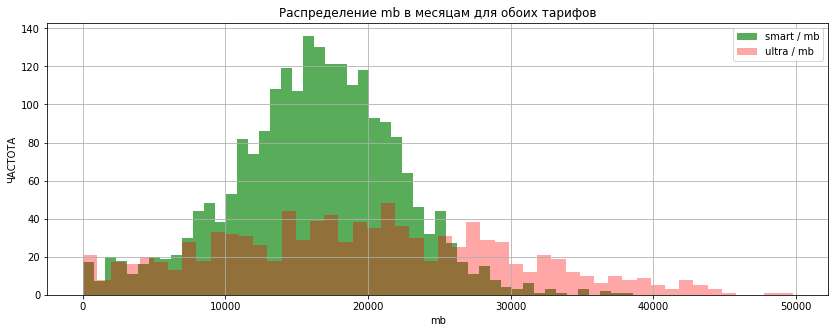

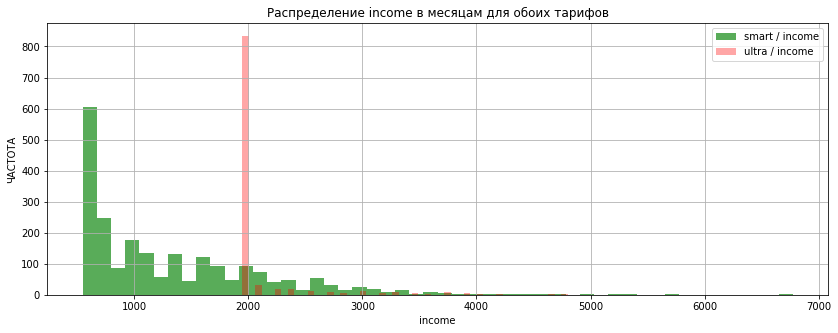

In [48]:
for param in ['min', 'mes', 'mb','income']:
    b = 50
    plt.figure(figsize=(14, 5))
    
    plt.hist(abonents.loc[abonents['tariff'] == "smart", param], label='smart / '+param, color='g', alpha=0.65, bins = b)
    plt.hist(abonents.loc[abonents['tariff'] == "ultra", param], label='ultra / '+param, color='r', alpha=0.35, bins = b)
    
    plt.ylabel('ЧАСТОТА')
    plt.xlabel(param)
    plt.grid()
    plt.title(f'Распределение {param} в месяцам для обоих тарифов')
    plt.legend()
    plt.show();

### Среднее количество, дисперсия и стандартное отклонение

Создадим новый датафрейм stat_frame и запишем в него все рассчитываемые статистические значения:

Таблица stat_frame - статистика для выборки. 
Столбцы:
parameter - (min-минуты, mes-СМС, mb-трафик)
mean - среднее
var - дисперсия
std - стандартное отклонение
tariff - тариф (smart, ultra, all-по обоим тарифам)

In [49]:
stat_frame = pd.DataFrame(columns = ['parameter', 'mean', 'var', 'std', 'tariff'])

ind = 0
t = ['smart', 'ultra', 'all']
for param in ['min', 'mes', 'mb', 'income']:
    tariff_ind = 0
    for df in [smart, ultra, tar]:
        stat_frame.loc[ind, 'parameter'] = param
        stat_frame.loc[ind, 'mean'] = round(df[param].mean(),1)
        stat_frame.loc[ind, 'var'] = round(np.var(df[param], ddof=1),1) # Поскольку данные являются выборкой, это указано
        stat_frame.loc[ind, 'std'] = round(np.std(df[param], ddof=1),1) # в условии, то ипользуем параметр - ddof=1
        stat_frame.loc[ind, 'tariff'] = t[tariff_ind]
        ind +=1
        tariff_ind +=1
stat_frame

,parameter,mean,var,std,tariff
0,min,386.6,5198.3,72.1,smart
1,min,495.6,5925.4,77.0,ultra
2,min,441.1,8416.0,91.7,all
3,mes,31.4,26.0,5.1,smart
4,mes,43.7,150.5,12.3,ultra
5,mes,37.5,123.7,11.1,all
6,mb,15073.2,7124616.3,2669.2,smart
7,mb,18209.8,8831918.9,2971.9,ultra
8,mb,16641.5,10197858.2,3193.4,all
9,income,1195.6,58335.5,241.5,smart


Рассчитаем доли стандартных отклонений в среднем - добавим столбец %std 

In [50]:
stat_frame['%std'] = stat_frame['std'] / stat_frame['mean'] * 100
stat_frame

,parameter,mean,var,std,tariff,%std
0,min,386.6,5198.3,72.1,smart,18.649767
1,min,495.6,5925.4,77.0,ultra,15.536723
2,min,441.1,8416.0,91.7,all,20.788937
3,mes,31.4,26.0,5.1,smart,16.242038
4,mes,43.7,150.5,12.3,ultra,28.146453
5,mes,37.5,123.7,11.1,all,29.6
6,mb,15073.2,7124616.3,2669.2,smart,17.70825
7,mb,18209.8,8831918.9,2971.9,ultra,16.320333
8,mb,16641.5,10197858.2,3193.4,all,19.189376
9,income,1195.6,58335.5,241.5,smart,20.199063


Из таблицы stat_frame и её средних значений видно, что медианные значения располагаются правее средних. Это говорит о скошенности данных влево, то есть бОльшая "весомая масса" значений" расположены меньше медианых значений. По стандартным отклонениям можно сказать, что они вполне адекватные (доля %std примерно от 18 до 24 %), за иключением сообщений (mes) на тарифе ultra - здесь доля %std около 42,8%. Это говорит о том что присутствует много абонентов, которые отправляют очень мало СМС ( это очень хорошо видно на гистограмме). В выручке income можно выделить то, что в тарифе ultra стандартное отклонение равно нулю (и дисперсия соответственно тоже) так как все платят одну и ту же сумму 1950р (мы исходили из медианных значений, если бы было взято среднее, то отклонение было бы, но маленькое).

## Проверка гипотез 

- средняя выручка пользователей тарифов smart и ultra отличается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

### Гипотеза №1: средняя выручка пользователей тарифов smart и ultra отличается 

In [51]:
#Запишем выручку по обоим тарифам в 2 датафрейма: ultra_income_mean и smart_income_mean.

ultra_income_mean = abonents.query('tariff =="ultra"')['income'].values
smart_income_mean = abonents.query('tariff =="smart"')['income'].values

# Выведем на экран дисперсию

print('Дисперсия smart_income_mean =', np.var(smart_income_mean), '// Дисперсия ultra_income_mean =', \
      np.var(ultra_income_mean))

Дисперсия smart_income_mean = 660979.9953686984 // Дисперсия ultra_income_mean = 142955.91886821177


Очевидно,что дисперсия сильно отличается (в 4,6 раза). Поэтому для проведения теста возьмем equal_var = False, alpha = 0.05

Нулевая гипотеза H₀: средняя выручка пользователей тарифов  ultra и smart равна; 
Альтернативная гипотеза H₁: средняя выручка пользователей тарифов ultra и smart различается.


In [52]:
from scipy import stats as st

alpha = 0.05

results = st.ttest_ind(smart_income_mean, ultra_income_mean, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.5941480288105795e-244
Отвергаем нулевую гипотезу


Соответственно альтернативная гипотез получила подтверждение. 

### Гипотеза №2: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов 

In [53]:
#Запишем выручку по обоим тарифам в 2 датафрейма: moscow_income_mean для Москвы, other_income_mean для остальных

moscow_income_mean = abonents.query('city == "Москва"')['income'].values
other_income_mean = abonents.query('city != "Москва"')['income'].values

print('Дисперсия moscow_income_mean =', np.var(moscow_income_mean), '// Дисперсия other_income_mean =', \
      np.var(other_income_mean))

Дисперсия moscow_income_mean = 555126.1226129793 // Дисперсия other_income_mean = 643914.3305976621


Очевидно, что дисперсия не сильно отличается: разница около 16%. 
Поэтому для проведения теста возьмем equal_var = True, alpha = 0.05

Нулевая гипотеза H₀: средняя выручка пользователей из Москвы и других городов равна; 
Альтернативная гипотеза H₁: средняя выручка пользователей из Москвы и других городов отличается.

In [54]:
from scipy import stats as st

alpha = 0.05

results = st.ttest_ind(moscow_income_mean, other_income_mean, equal_var = True)

print('p-значение:', results.pvalue) 

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.495399331911754
Не получилось отвергнуть нулевую гипотезу


Альтернативная гипотеза не подтвердилась.

## Общий вывод

Вывод: В тарифе smart подавляющее большинство абонентов укладываются в лимит 500 минут разговора (среднее значение за 2018 год - 421 минута), да и в тарифе ultra недалеко ушли от этого значения - среднемесячное не больше 600 минут. Также можно наблюдать, что расход минут постепенно возрастает в течение года. Исключение: в феврале у тарифа ultra довольно сильное падение, почти в 2 раза. Также надо отметить, что в тарифе smart в январе и феврале мало звонят - тоже в 2 раза меньше, чем в другие месяцы

СМС - не очень популярная услуга (много абонентов, которые вообще не пишут СМС или пишут очень мало). Абоненты тарифа smart вполне укладываются в лимит 50 СМС (а среднее 28 СМС в месяц за год), даже абоненты тарифа ultra редко превышают порог в 50 СМС (скорее всего это какие-то интернет-сервисы или магазины). Видно, что на тарифе ultra СМС ближе к концу года пишут всё чаще и чаще, исключение - январь где наблюдаются, более высокая активность. В тарифе smart в первой половине года активность постепенно возрастает, а во второй держится примерно на одном уровне.

А вот с интернет-трафиком другая ситуация. Абоненты smart любят посидеть в интернете и часто превышают лимит в 15360 МБ, даже среднее значение выше - 16073 МБ, также надо отметить, что опять начало года (январь и февраль) характеризовано низкой активностью в интернете (около 7,5 ГБ). В тарифе ultra опять сильный провал в феврале (в 2 раза), а в остально часть года идет постепенный рост; средний расход трафика на smart довольно невысокий: несмотря на порог в 30 ГБ средний расход около 18,8 ГБ. Подавляющее большинство абонентов расходуют от 11 до 23 ГБ трафика в месяц.

Выручка абонентов ultra в подавляющем большинстве случаев ограничивается абонентской платой(1950р), а абоненты smart, наоборот, часто платят сверх абонентской платы, в среднем 482р - на 87,5% больше абонентской платы. Средства идут, в основном, на оплату интернет трафика.

В принципе, многие абоненты ultra могли бы перейти на тариф smart и платили бы меньше - если исходить из усредненных значений: 510мин (10 сверх лимита в 500) 103 = 30р. Трафик 18831 МБ (3471 (4ГБ) сверх 15360 МБ) 4200 = 800р Итого = 550 + 30 + 800 = 1380р , а платят 1950 ! Так что тариф smart очевидно намного выгоднее, чем тариф ultra.

Во время проведения анализа была создана таблица stat_frame, куда были записаны: среднее количество, дисперсия и стандартное отклонение для 4 параметров (минуты разговора, СМС, кол-во интернет-трафика, выручка) по каждому тарифу ultra и smart и по объединенным значениям обоих тарифов

Также были проверены две гипотезы:
1) Гипотеза №1: средняя выручка пользователей тарифов ultra и smart отличается: ГИПОТЕЗА ПОДТВЕРДИЛАСЬ;
2) Гипотеза №2: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов: ГИПОТЕЗА НЕ ПОДТВЕРДИЛАСЬ.

В итоге можно рекомендовать оператору продвигать тариф smart. Он приносит больше выручки (это очень весомый фактор для оператора), его абоненты очень часто переплачивают сверх лимита, в отличие от абонентов ultra, которые очень редко выбирают свой лимит. Также по абонентской плате он более привлекателен для абонентов - а это очень весомый аргумент для пользователей при выборе тарифа. 